# Exam Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/fabiogueunige/Trustworthy/blob/HEAD/04-Solution_Example.ipynb)  

## Here you find:  


In [12]:
try:
    import secml
    import foolbox
    import sklearn
except Exception:
    %pip install 'secml[pytorch]' foolbox

# Exercise 1

Complete the following tasks using SecML

Create a SVM with scikit-learn (use SVC, leave the default parameters) and wrap it with the scikit-learn SecML wrapper seen during the course.

In [13]:
from sklearn.svm import SVC
from secml.ml.classifiers import CClassifierSkLearn

model = SVC()
secml_model = CClassifierSkLearn(model)

Create a dataset consisting of 500 samples of 2D points from two clusters (CDLRandomBlobs), whose centers are located in (-2, 2) and (2,2) with standard deviation = 0.5. Normalize the dataset between 0 and 1 (CNormalizerMinMax).

In [14]:
random_state = 123

n_features = 2   # number of features
n_samples = 500   # number of samples
centers = [[-2, 2], [2, 2]]   # centers of the clusters
cluster_std = 0.5   # standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
dataset.X = nmz.fit_transform(dataset.X)

Divide the data with the SecML splitter (CTrainTestSplit), using 400 samples per il training e 100 per il test.

In [15]:
n_tr = 400  # number of training set samples
n_ts = 100  # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

Fit the classifier on the training data.

In [16]:
secml_model.fit(tr.X, tr.Y)

CClassifierSkLearn{'sklearn_model': SVC(), 'classes': CArray(2,)(dense: [0 1]), 'n_features': 2, 'preprocess': None, 'n_jobs': 1}

Compute the accuracy on the test set using the CMetricAccuracy object.

In [17]:
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()
accuracy = metric.performance_score(secml_model.predict(ts.X), ts.Y)
print(accuracy)

1.0


Plot the learned decision function using the ad-hoc method of the CFigure class.

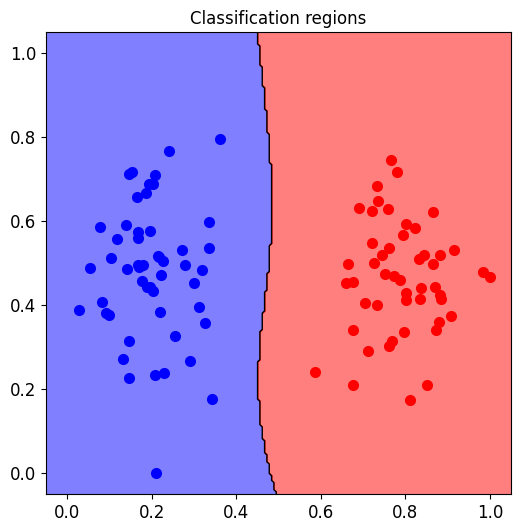

In [18]:
%matplotlib inline

from secml.figure import CFigure

fig = CFigure()

# convenience function for plotting the decision function of a classifier
fig.sp.plot_decision_regions(secml_model, n_grid_points=200)

fig.sp.plot_ds(ts)
fig.sp.grid(grid_on=False)

fig.sp.title("Classification regions")
fig.show()

# Exercise 2

We provide you the code for training a simple model on 2D data. Execute the cell to create and fit the model.

Accuracy is 1.0


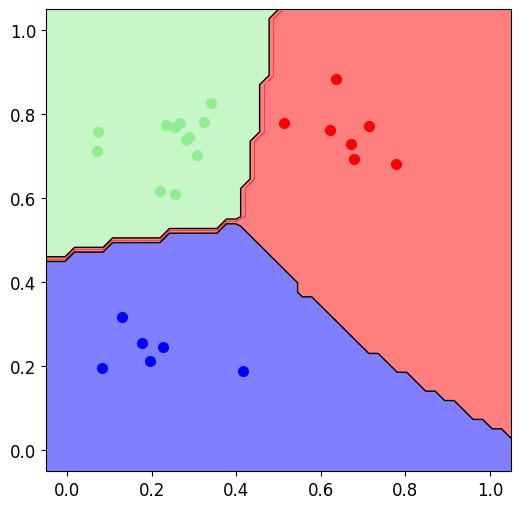

In [19]:
import torch
torch.manual_seed(111)
from torch.nn.functional import relu, softmax
from torch.optim import SGD
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.features import CNormalizerMinMax

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = torch.nn.Linear(2, 50)
        self.lin2 = torch.nn.Linear(50, 50)
        self.lin3 = torch.nn.Linear(50, 3)

    def forward(self, x):
        x = relu(self.lin1(x))
        x = relu(self.lin2(x))
        y = self.lin3(x)
        return y

net = Net()
optimizer = SGD(net.parameters(), lr=0.01, momentum=0.9)
loss_function = torch.nn.CrossEntropyLoss()
from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=net,
                         loss=loss_function,
                         optimizer=optimizer,
                         epochs=30,
                         batch_size=32,
                         random_state=31)


dataset = CDLRandomBlobs(n_features=2,
                         centers=[[0,0], [1,1], [0,1]],
                         cluster_std=0.2,
                         n_samples=500,
                         random_state=111).load()

dataset.X = CNormalizerMinMax().fit_transform(dataset.X)
splitter = CTrainTestSplit(train_size=475, test_size=25, random_state=8)
tr, ts = splitter.split(dataset)

clf.fit(tr.X, tr.Y)

print(f"Accuracy is {CMetricAccuracy().performance_score(clf.predict(ts.X), ts.Y)}")
fig = CFigure()
fig.sp.plot_ds(ts)
fig.sp.plot_decision_regions(clf, n_grid_points=50)

Compute a security evaluation curve of the trained model using the corresponding SecML object (CSecEval) as shown in class, with the following setup.

* Use the CFoolboxPGDLInf attack from the SecML library, with 5 iterations and 0.05 as absolute step size, no random start, lower bound 0 and upper bound 1;

* Use at least 5 values for the perturbation budget epsilon.
Since it is an L-inf attack and the domain is bounded between 0 and 1, which is the maximum perturbation norm that the attack can reach?



In [20]:
from secml.adv.attacks.evasion import CFoolboxPGDLinf
from secml.adv.seceval import CSecEval

pgd_attack = CFoolboxPGDLinf(clf, None,
                           lb=0, ub=1,
                           epsilons=0,
                           abs_stepsize=0.05,
                           steps=5,
                           random_start=False)

epsilons = [0.01, 0.1, 0.3, 0.6, 1] # Here we set 1 as maximum value for the LINF attack, since it will cover all the input domain.
sec_eval = CSecEval(attack=pgd_attack, param_name='epsilon', param_values=epsilons)
sec_eval.run_sec_eval(ts)


Plot the security evaluation curve using the ad-hoc method of the CFigure class.

2024-01-11 15:35:48,796 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


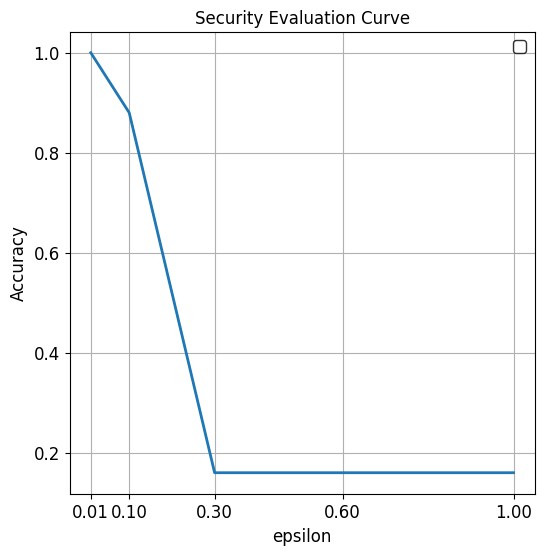

In [21]:
fig = CFigure()
fig.sp.plot_sec_eval(sec_eval.sec_eval_data)

# Exercise 3

We provide the code for an example implementation of gradient descent attack.
The implementation contains a bug: find it, fix it, and motivate your choice.

Original label 1
Adv label: 2


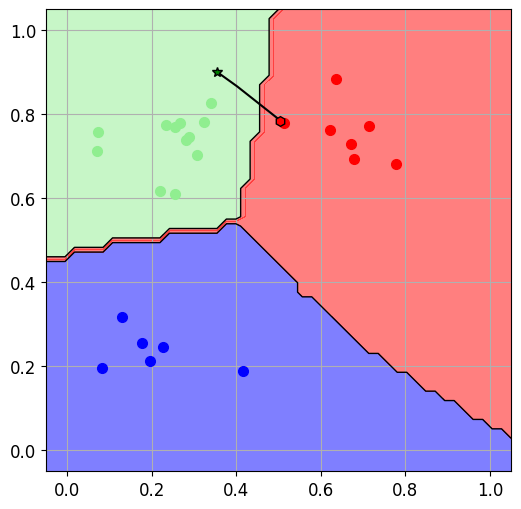

In [22]:
from secml.array import CArray
from secml.ml import CClassifier
from secml.ml.classifiers.loss import CLossCrossEntropy
import copy

%matplotlib inline

# TO READ BEFORE: for the solution of this exericise, I also added some instructions to visualize the effect of the attack.
# This implementation of PGD was missing the STEPSIZE multiplication.
# Thus, the gradient was not scaled after its normalization.

def pgd_l2_targeted(clf : CClassifier, x : CArray, y_original : CArray, y_target : int, steps : int=20, eps : float=0.5, step_size : float=0.05, lb : int = 0, ub : int = 1):
    loss_func = CLossCrossEntropy()
    x_adv = x.deepcopy()
    path = CArray.zeros((steps, 2))
    for i in range(steps):
        scores = clf.decision_function(x_adv)
        targets = CArray.zeros((1, 3))
        targets[scores.argmax()] = 1
        loss_func_val = loss_func.loss(y_original, targets)
        # this is dL / df_yt
        loss_gradient = loss_func.dloss(y_true=y_original, score=scores, pos_label=y_target)
        # This is the df_yt / dx
        clf_gradient = clf.grad_f_x(x_adv, y_target)
        gradient = clf_gradient * loss_gradient

        if gradient.norm() != 0:
            gradient /= gradient.norm()

        x_adv = x_adv + step_size * gradient # The bug was here, step_size was missing.
        delta = x_adv - x
        if delta.norm() > eps:
            delta = delta / delta.norm()
            x_adv = x + delta * eps
        x_adv = x_adv.clip(lb, ub)
        path[i, :] = x_adv

    scores = clf.decision_function(x_adv)
    print(f'Adv label: {scores.argmax()}')
    return x_adv, path

# NB: I added this code AFTER the exam, to better explain the solution.
print("Original label", ts.Y[0].item())
x_adv, path = pgd_l2_targeted(clf, ts.X[0,:], ts.Y[0], 2, step_size=0.01)

fig = CFigure()
fig.sp.plot_decision_regions(clf, n_grid_points=50)
fig.sp.plot_ds(ts)
fig.sp.plot_path(path)